In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Reading the data

This credit card data is very similar to that of UCI data repository. It can also be found in the Kaggle website [here](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)

In [3]:
df = pd.read_csv("df_dev.csv")
df.head()

,ID,credit_limit,card_type,gender,education,age,pay_status_1,pay_status_2,pay_status_3,pay_status_4,...,bill_amount_2,bill_amount_3,bill_amount_4,bill_amount_5,pay_amount_1,pay_amount_2,pay_amount_3,pay_amount_4,pay_amount_5,Default
0,10000,310000,VISA,1,3,32,0,0,0,0,...,152397,110375,84373,57779,8295,6000,4000,3000,1000,0
1,10001,10000,NaN,2,3,49,-1,-1,-2,-1,...,-358,-748,1690,1138,0,0,2828,0,182,1
2,10002,50000,MASTER,1,2,30,-1,-1,-1,0,...,0,46257,45975,1300,0,46257,2200,1300,43987,0
3,10003,80000,VISA,2,3,52,2,2,3,3,...,39448,40101,40748,39816,3700,1600,1600,0,1600,1
4,10004,270000,NaN,1,1,36,1,2,0,0,...,17228,20924,22448,15490,0,4000,2000,0,2000,0


In [4]:
df.shape

(20000, 22)

In [5]:
df.isnull().sum()

ID                  0
credit_limit        0
card_type        6630
gender              0
education           0
age                 0
pay_status_1        0
pay_status_2        0
pay_status_3        0
pay_status_4        0
pay_status_5        0
bill_amount_1       0
bill_amount_2       0
bill_amount_3       0
bill_amount_4       0
bill_amount_5       0
pay_amount_1        0
pay_amount_2        0
pay_amount_3        0
pay_amount_4        0
pay_amount_5        0
Default             0
dtype: int64

In [6]:
#Only missing value is in card_type,,, could be changed to other

## Data description

* credit_limit: Credit limit of the crad
* card_type: The type of credit card
* gender: The gender of the account owner
* education: Education level of the account owner:
    - 1: graduate school
    - 2: university
    - 3: high school
    - 4: others
    - 5 & 6: unknown
* Age: age of the account owner
* pay_status_i: Payment status of the i-th month before current month
    - -1: pay duly
    - k for 1 <= k <= 8: payment delay for k months
    - 9: payment delay for nine months or above
* bill_amount_i: statement balance of the i-th month before current month
* pay_amount_i:  amount of payment made in the i-th month before current month
* Default: Indicator of default for the next month (Target Variable)
    - 1: Default
    - 0: non-default

# Project aim

The aim of the project is to follow best-practice modelling decisions and build an XGBoost model for predicting whether a credit card account will default in the next month. Please perform appropriate performance assessment and explain-ability/interpretability analyses on your model and feel free to make reasonable assumptions wherever needed.



# EDA and Feature selection

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             20000 non-null  int64 
 1   credit_limit   20000 non-null  int64 
 2   card_type      13370 non-null  object
 3   gender         20000 non-null  int64 
 4   education      20000 non-null  int64 
 5   age            20000 non-null  int64 
 6   pay_status_1   20000 non-null  int64 
 7   pay_status_2   20000 non-null  int64 
 8   pay_status_3   20000 non-null  int64 
 9   pay_status_4   20000 non-null  int64 
 10  pay_status_5   20000 non-null  int64 
 11  bill_amount_1  20000 non-null  int64 
 12  bill_amount_2  20000 non-null  int64 
 13  bill_amount_3  20000 non-null  int64 
 14  bill_amount_4  20000 non-null  int64 
 15  bill_amount_5  20000 non-null  int64 
 16  pay_amount_1   20000 non-null  int64 
 17  pay_amount_2   20000 non-null  int64 
 18  pay_amount_3   20000 non-n

In [8]:
#seperating categorial and numerical variables

num_cols = ["credit_limit", "age", 'pay_status_1', 'pay_status_2',
            'pay_status_3', 'pay_status_4', 'pay_status_5', 'bill_amount_1', 'bill_amount_2',
            'bill_amount_3', 'bill_amount_4', 'bill_amount_5', 'pay_amount_1',
            'pay_amount_2', 'pay_amount_3', 'pay_amount_4', 'pay_amount_5']

cat_cols = ["gender", "card_type", "education"]

for col in cat_cols:
    print(df[col].value_counts().sort_index(), "\n")

1     7916
2    12084
Name: gender, dtype: int64 

MASTER    6683
VISA      6687
Name: card_type, dtype: int64 

0       8
1    7123
2    9295
3    3260
4      93
5     183
6      38
Name: education, dtype: int64 



In [9]:
#grouping 0,5,6 with 4=Others
df['education']=np.where(df['education'] == 5, 4, df['education'])
df['education']=np.where(df['education'] == 6, 4, df['education'])
df['education']=np.where(df['education'] == 0, 4, df['education'])
df.education.value_counts()

2    9295
1    7123
3    3260
4     322
Name: education, dtype: int64

In [10]:
df.card_type.isnull().sum()

6630

In [11]:
#change NaN in card type to a category of its own
df.card_type = np.where(df.card_type.isnull(), "Other", df.card_type)

df.card_type.value_counts()

VISA      6687
MASTER    6683
Other     6630
Name: card_type, dtype: int64

In [12]:
#Marking categorical columns astype(categorical)
for col in cat_cols:
    df[col] = df[col].astype('category')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   ID             20000 non-null  int64   
 1   credit_limit   20000 non-null  int64   
 2   card_type      20000 non-null  category
 3   gender         20000 non-null  category
 4   education      20000 non-null  category
 5   age            20000 non-null  int64   
 6   pay_status_1   20000 non-null  int64   
 7   pay_status_2   20000 non-null  int64   
 8   pay_status_3   20000 non-null  int64   
 9   pay_status_4   20000 non-null  int64   
 10  pay_status_5   20000 non-null  int64   
 11  bill_amount_1  20000 non-null  int64   
 12  bill_amount_2  20000 non-null  int64   
 13  bill_amount_3  20000 non-null  int64   
 14  bill_amount_4  20000 non-null  int64   
 15  bill_amount_5  20000 non-null  int64   
 16  pay_amount_1   20000 non-null  int64   
 17  pay_amount_2   20000 non-null  

## Target variable

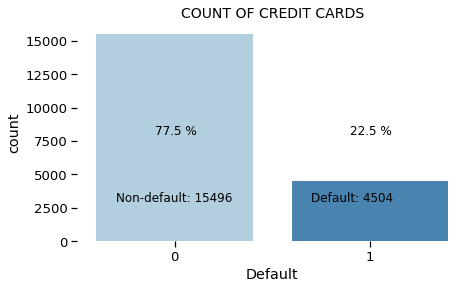

In [14]:
# The frequency of defaults
yes = df.Default.sum()
no = len(df)-yes

# Percentage
yes_perc = round(yes/len(df)*100, 1)
no_perc = round(no/len(df)*100, 1)

import sys 
plt.figure(figsize=(7,4))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('Default', data =df, palette="Blues")
plt.annotate('Non-default: {}'.format(no), xy=(-0.3, 15000), xytext=(-0.3, 3000), size=12)
plt.annotate('Default: {}'.format(yes), xy=(0.7, 15000), xytext=(0.7, 3000), size=12)
plt.annotate(str(no_perc)+" %", xy=(-0.3, 15000), xytext=(-0.1, 8000), size=12)
plt.annotate(str(yes_perc)+" %", xy=(0.7, 15000), xytext=(0.9, 8000), size=12)
plt.title('COUNT OF CREDIT CARDS', size=14)
#Removing the frame
plt.box(False);

## Correlation among numerical vars

In [15]:
corr = df[num_cols].corr()
#cor_value.style.background_gradient(cmap='coolwarm')
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .format(precision = 2))

,credit_limit,age,pay_status_1,pay_status_2,pay_status_3,pay_status_4,pay_status_5,bill_amount_1,bill_amount_2,bill_amount_3,bill_amount_4,bill_amount_5,pay_amount_1,pay_amount_2,pay_amount_3,pay_amount_4,pay_amount_5
credit_limit,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,0.15,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pay_status_1,-0.27,-0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pay_status_2,-0.29,-0.05,0.66,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pay_status_3,-0.28,-0.06,0.57,0.77,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pay_status_4,-0.26,-0.05,0.54,0.66,0.78,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pay_status_5,-0.25,-0.06,0.51,0.62,0.68,0.82,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bill_amount_1,0.29,0.06,0.19,0.24,0.22,0.21,0.21,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bill_amount_2,0.29,0.06,0.19,0.24,0.25,0.24,0.23,0.95,nan,nan,nan,nan,nan,nan,nan,nan,nan
bill_amount_3,0.29,0.06,0.18,0.23,0.24,0.25,0.25,0.89,0.93,nan,nan,nan,nan,nan,nan,nan,nan


> bill amounts are highly correlated with each other. On the next level, every consecutive pair of pay_status_i  are also correlated with each other.

In [16]:
df.groupby("Default").mean()

,ID,credit_limit,age,pay_status_1,pay_status_2,pay_status_3,pay_status_4,pay_status_5,bill_amount_1,bill_amount_2,bill_amount_3,bill_amount_4,bill_amount_5,pay_amount_1,pay_amount_2,pay_amount_3,pay_amount_4,pay_amount_5
Default,,,,,,,,,,,,,,,,,,
0,19977.346477,177871.837894,36.418301,-0.205472,-0.303433,-0.319824,-0.357060,-0.391972,52408.648232,50089.398877,47843.682499,43845.768456,40859.523361,6366.695405,6548.245289,5688.543172,5437.977607,5338.766714
1,20075.719139,130748.223801,36.733126,0.658304,0.434281,0.349245,0.242673,0.158748,48856.618561,47806.209369,45789.014876,42441.404973,39988.317940,3480.064831,3535.235790,3392.924067,3092.736234,3249.658970


## Categorical Variables

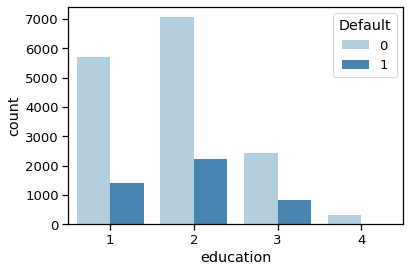

In [17]:
ax3 = sns.countplot(x="education", hue="Default", data=df, palette="Blues")
plt.show()

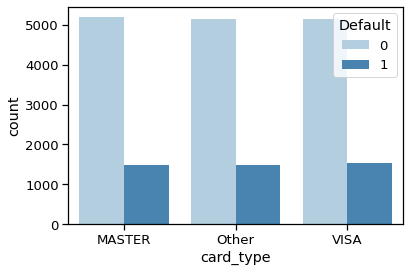

In [18]:
ax3 = sns.countplot(x="card_type", hue="Default", data=df, palette="Blues")
plt.show()

In [19]:
df.columns

Index(['ID', 'credit_limit', 'card_type', 'gender', 'education', 'age',
       'pay_status_1', 'pay_status_2', 'pay_status_3', 'pay_status_4',
       'pay_status_5', 'bill_amount_1', 'bill_amount_2', 'bill_amount_3',
       'bill_amount_4', 'bill_amount_5', 'pay_amount_1', 'pay_amount_2',
       'pay_amount_3', 'pay_amount_4', 'pay_amount_5', 'Default'],
      dtype='object')

In [20]:
#sns.pairplot(df.drop("ID", axis = 1).iloc[:1000,], hue='Default')


In [21]:
sns.

SyntaxError: invalid syntax (Temp/ipykernel_15680/1118962691.py, line 1)

## Feature Importance - Mutual Information 

In [ ]:
df.education.value_counts()

In [ ]:
edf, _ = df.card_type.factorize()

pd.Series(edf).value_counts()

> __From Kaggle [courses](https://www.kaggle.com/ryanholbrook/mutual-information)__: The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding (as we have in our data).

In [25]:
X = df.drop(["ID"] ,axis = 1)
y = X.pop("Default")

#This may seem like a redo but it was important to have these columns as categorical in the EDA and visualizations
for col in X.select_dtypes("category"):
    X[col], _ = X[col].factorize()

#now all features are integers (numbers)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   credit_limit   20000 non-null  int64
 1   card_type      20000 non-null  int64
 2   gender         20000 non-null  int64
 3   education      20000 non-null  int64
 4   age            20000 non-null  int64
 5   pay_status_1   20000 non-null  int64
 6   pay_status_2   20000 non-null  int64
 7   pay_status_3   20000 non-null  int64
 8   pay_status_4   20000 non-null  int64
 9   pay_status_5   20000 non-null  int64
 10  bill_amount_1  20000 non-null  int64
 11  bill_amount_2  20000 non-null  int64
 12  bill_amount_3  20000 non-null  int64
 13  bill_amount_4  20000 non-null  int64
 14  bill_amount_5  20000 non-null  int64
 15  pay_amount_1   20000 non-null  int64
 16  pay_amount_2   20000 non-null  int64
 17  pay_amount_3   20000 non-null  int64
 18  pay_amount_4   20000 non-null  int64
 19  pay_

In [26]:
#marking the discrete (non-continous) features
# again because of the ordinal nature pay_status_i vars, they are mark as non-discrete
discrete_features = X.dtypes != "int64"
discrete_features[cat_cols] = True
#discrete_features[discrete_features.index.str.startswith("pay_status")] = True ##This doesn't affect the MI scores in our case

In [27]:
from sklearn.feature_selection import mutual_info_classif


def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  # show a few features with their MI scores

pay_status_1     0.075703
pay_status_2     0.051033
pay_status_3     0.037859
pay_status_4     0.036976
pay_status_5     0.030538
pay_amount_1     0.022804
pay_amount_2     0.016541
pay_amount_5     0.015305
pay_amount_3     0.014507
credit_limit     0.012897
pay_amount_4     0.012739
bill_amount_1    0.007351
bill_amount_4    0.006903
education        0.006705
bill_amount_5    0.005637
bill_amount_2    0.005178
age              0.003777
card_type        0.003499
bill_amount_3    0.002781
gender           0.000000
Name: MI Scores, dtype: float64

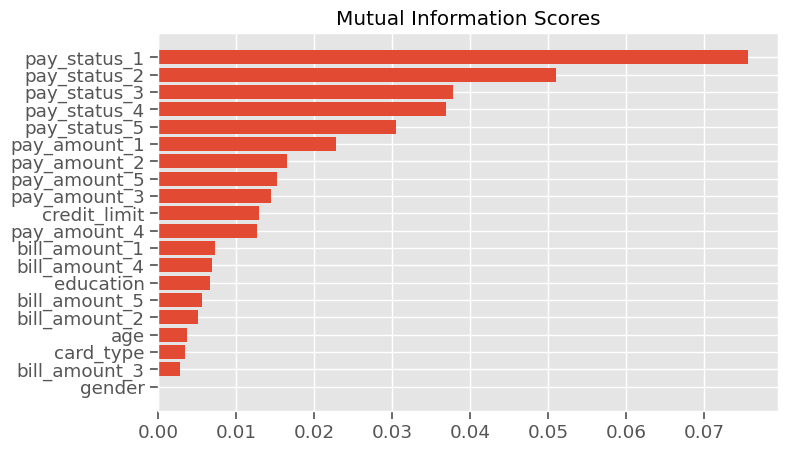

In [28]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

>  __Important Note: MI method is univariate and does not take correlation among features into account. Therefore, before building the model, collinearity must be addressed.__

# XGBoost to predict credit card default

In [29]:
plt.style.use('ggplot') # nice plots

from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold # for cross validation
from sklearn.model_selection import GridSearchCV # for tuning parameter
from sklearn.model_selection import RandomizedSearchCV  # Randomized search on hyper parameters.
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model

import matplotlib.pyplot as plt

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## A simple model to begin with

In [31]:
params = {
        "n_jobs": 4,
        "learning_rate": 0.05,
        "eval_metric": "auc",
        "max_depth" : 6,
        "n_estimators":500,
       # "min_child_weight":1,
      # "gamma":0,
        "subsample":0.8,
        "colsample_bytree":0.8,
        "objective": 'binary:logistic',
        #"scale_pos_weight":1,
        "seed":27
}

eval_set = [(x_train, y_train), (x_test, y_test)]
myModel = XGBClassifier(**params)

myModel.fit(x_train, y_train, eval_metric=["auc", "aucpr", "error", "logloss"], eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

Total Accuracy: 80.67%


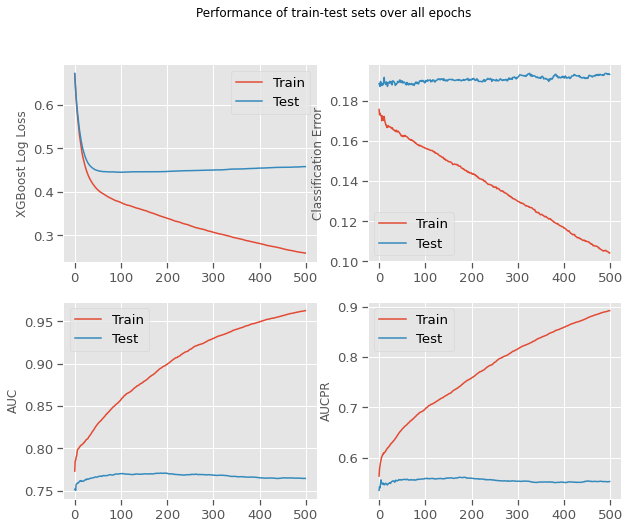

In [32]:
y_pred = myModel.predict_proba(x_test)[:,1] #gives 
predictions = [round(value) for value in y_pred] #this gives label w 0.5 threshold

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Total Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = myModel.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
ax1.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax1.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax1.legend()
ax1.set_ylabel("XGBoost Log Loss")

ax2.plot(x_axis, results['validation_0']['error'], label='Train')
ax2.plot(x_axis, results['validation_1']['error'], label='Test')
ax2.legend()
ax2.set_ylabel('Classification Error')
#plt.title('XGBoost Classification Error')

ax3.plot(x_axis, results['validation_0']['auc'], label='Train')
ax3.plot(x_axis, results['validation_1']['auc'], label='Test')
ax3.legend()
ax3.set_ylabel('AUC')

ax4.plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax4.plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax4.legend()
ax4.set_ylabel('AUCPR')
fig.suptitle("Performance of train-test sets over all epochs")
plt.show()

> This clearly shows that the model has overfitted after all 500 epochs, therefore we need to add a stopping criteria

0    0.8695
1    0.1305
Name: label, dtype: float64


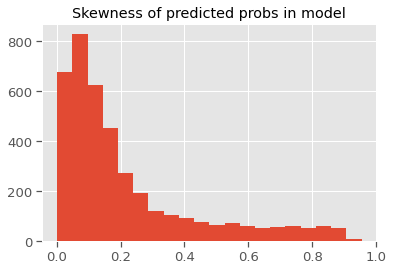

In [29]:
_x = pd.DataFrame({"label" : predictions, "prob":y_pred})
print(_x.label.value_counts(normalize=True))

_x.prob.hist(bins = 20)
plt.title("Skewness of predicted probs in model")
plt.show()

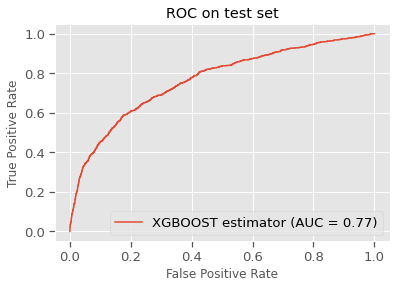

In [176]:

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBOOST estimator')
display.plot()
plt.title("ROC on test set")
plt.show()

### Threshold for predicted labels

In imbalanced data sets, setting the right threshold is an important decision. Below we can change the cut-off threshold for predicted probabilities and see how it changes the confusion matrix.

In [182]:

thr = 0.5
y_pred_labeled = np.where(y_pred > thr, 1, 0)
metrics.precision_score(y_test, y_pred_labeled)

0.6443594646271511

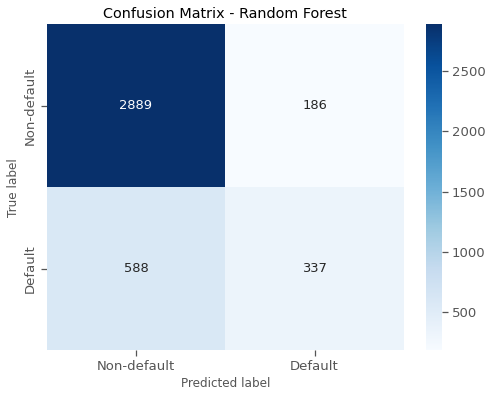

In [183]:
plt.figure(figsize=(8,6))
ConfMatrix = confusion_matrix(y_test,y_pred_labeled)
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", annot_kws={"size": 13},
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - XGBoost");

> False Negatives are too many!

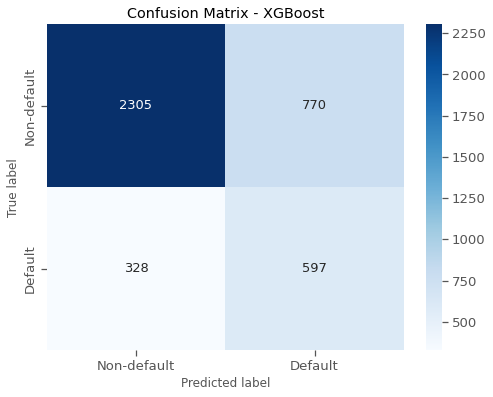

In [34]:
thr = 0.2
y_pred_labeled = np.where(y_pred > thr, 1, 0)
metrics.precision_score(y_test, y_pred_labeled)

plt.figure(figsize=(8,6))
ConfMatrix = confusion_matrix(y_test,y_pred_labeled)
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", annot_kws={"size": 13},
            xticklabels = ['Non-default', 'Default'], 
            yticklabels = ['Non-default', 'Default'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix - XGBoost");

> Now we have a higher Recall at the cost of Precision becoming lower. So, there is a trade-off in choosing the right cut-off point

## Cross Validation and Parametere Tuning

XGBoost like any ML model needs to be tuned to perform the best.

In [185]:
params = {
        "n_jobs": 4,
        "learning_rate": 0.05,
        "eval_metric": "auc",
        "max_depth" : 6,
        "n_estimators":500,
       # "min_child_weight":1,
      # "gamma":0,
        "subsample":0.8,
        "colsample_bytree":0.8,
        "objective": 'binary:logistic',
        #"scale_pos_weight":1,
        "seed":27
}

eval_set = [(x_train, y_train), (x_test, y_test)]
myModel = XGBClassifier(**params)

myModel.fit(x_train, y_train, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=10, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, eval_metric='auc', gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=27, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [81]:

cnt = pd.Series(y_train).value_counts(normalize = True)
print("Majority class to minority ratio: %.2f" % (cnt[0] / cnt[1]))

Majority class to minority ratio: 3.47


In [74]:
%%time

param_grid = {
    "max_depth" : range(3,10),
    "learning_rate" : [0.01, 0.05, 0.1, 0.2],
    "scale_pos_weight": [1, 2, 3, 4, 5],
    "n_estimators" : [50, 100, 200]
             }

params = {
        #"learning_rate": 0.05,
        "objective": 'binary:logistic',
        #"n_estimators":500,
        "seed": 27
}

myModel = XGBClassifier(**params)

grid = GridSearchCV(
    estimator=myModel,
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    scoring=["roc_auc", "f1"],
    refit = "roc_auc" #refits at the end on the selected best metric
)
#can see list of scoring metrics at `metrics.SCORERS.keys()`
grid_result = grid.fit(x_train, y_train)


[16:17:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 32min 56s


In [75]:
# report the best configuration
print("Highest %s (metric): %f using %s \n" % (grid.refit, grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_' + grid.refit]
stds = grid_result.cv_results_['std_test_' + grid.refit]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Highest roc_auc (metric): 0.780854 using {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 2} 

0.757929 (0.006751) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 1}
0.762069 (0.005315) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 2}
0.763004 (0.005612) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 3}
0.763814 (0.006167) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 4}
0.764178 (0.006741) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'scale_pos_weight': 5}
0.765609 (0.004736) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 1}
0.767064 (0.004303) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 2}
0.767487 (0.004654) with: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3

 One down aspect of the grid search above is that it did not use early stopping as we wanted to keep the test set, unseen! Now I use the parameters selected, tweak them a bit if needed in order to find the best ones.

In [165]:

eval_set = [(x_train, y_train), (x_test, y_test)]

params = grid_result.best_params_
###tried the following changes but results were nearly the identical.
params["scale_pos_weight"] = 4 #change
params["max_depth"] = 6 #change
bestGridModel = XGBClassifier(**params)

bestGridModel.fit(x_train, y_train, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=10, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7999999999999999,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=4,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

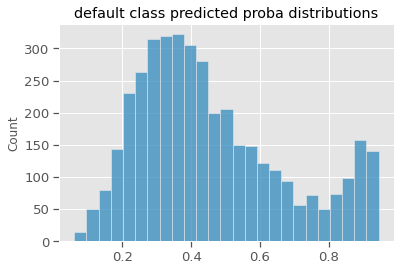

In [154]:
y_pred = bestGridModel.predict_proba(x_test)[:,1]
sns.histplot(y_pred)
plt.title("default class predicted proba distribution")
plt.show()
#probabilities are less skewed from the default model but still AUC has not improved much (0.01)

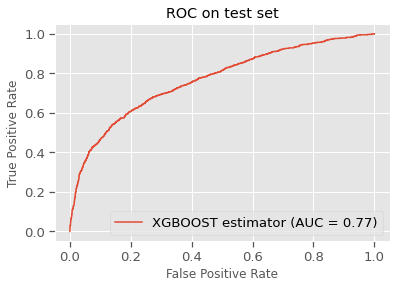

In [96]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBOOST estimator')
display.plot()
plt.title("ROC on test set")
plt.show()

In [ ]:
##find threshold

## Trying other approaches to increase performance

In [120]:
X.head()

X_new = X.drop(["bill_amount_2",
                "bill_amount_3",
                "bill_amount_4",
                "bill_amount_5"], axis = 1)
X_new.columns

Index(['credit_limit', 'card_type', 'gender', 'education', 'age',
       'pay_status_1', 'pay_status_2', 'pay_status_3', 'pay_status_4',
       'pay_status_5', 'bill_amount_1', 'pay_amount_1', 'pay_amount_2',
       'pay_amount_3', 'pay_amount_4', 'pay_amount_5'],
      dtype='object')

In [121]:
# Create a %10 validation set for 
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=123)
x_train, x_valid, y_train, y_valid =  train_test_split(x_train, y_train, test_size=0.125, random_state=123)

In [134]:
params = {
        "n_jobs": 4,
        "learning_rate": 0.05,
        "eval_metric": "auc",
        "max_depth" : 6,
        "n_estimators":500,
        "objective": 'binary:logistic',
        "seed":27
}

param_grid = {
    "max_depth" : range(3,10),
    "learning_rate" : [0.01, 0.05, 0.1, 0.2],
    "scale_pos_weight": [1, 2, 4, 8],
    "n_estimators" : [50, 100, 200],
    "colsample_bytree" : np.arange(0.5, 1.01, 0.1),
    "subsample" : np.arange(0.8, 1.01, 0.05)
             }

myModel = XGBClassifier(**params)

rand_grid = RandomizedSearchCV(
    estimator=myModel,
    param_distributions=param_grid,
    n_jobs=-1,
    cv=5,
    scoring=["roc_auc", "f1"],
    refit = "roc_auc" #refits at the end on the selected best metric
)

eval_set = [(x_valid, y_valid)]

grid_result = rand_grid.fit(x_train, y_train, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=20)


[0]	validation_0-auc:0.74141
[1]	validation_0-auc:0.77094
[2]	validation_0-auc:0.77114
[3]	validation_0-auc:0.77433
[4]	validation_0-auc:0.77184
[5]	validation_0-auc:0.77059
[6]	validation_0-auc:0.77033
[7]	validation_0-auc:0.77109
[8]	validation_0-auc:0.77153
[9]	validation_0-auc:0.77286
[10]	validation_0-auc:0.77295
[11]	validation_0-auc:0.77260
[12]	validation_0-auc:0.77348
[13]	validation_0-auc:0.77441
[14]	validation_0-auc:0.77510
[15]	validation_0-auc:0.77540
[16]	validation_0-auc:0.77558
[17]	validation_0-auc:0.77590
[18]	validation_0-auc:0.77593
[19]	validation_0-auc:0.77576
[20]	validation_0-auc:0.77540
[21]	validation_0-auc:0.77660
[22]	validation_0-auc:0.77678
[23]	validation_0-auc:0.77730
[24]	validation_0-auc:0.77776
[25]	validation_0-auc:0.77847
[26]	validation_0-auc:0.77863
[27]	validation_0-auc:0.77860
[28]	validation_0-auc:0.77872
[29]	validation_0-auc:0.77939
[30]	validation_0-auc:0.77975
[31]	validation_0-auc:0.77913
[32]	validation_0-auc:0.77871
[33]	validation_0-au

In [135]:
# report the best configuration
print("Highest %s (metric): %f using %s \n" % (grid.refit, grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_' + grid.refit]
stds = grid_result.cv_results_['std_test_' + grid.refit]
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Highest roc_auc (metric): 0.777981 using {'subsample': 0.8, 'scale_pos_weight': 4, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999} 

0.772388 (0.008598) with: {'subsample': 0.9000000000000001, 'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
0.772279 (0.010068) with: {'subsample': 0.9500000000000002, 'scale_pos_weight': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9999999999999999}
0.776418 (0.010923) with: {'subsample': 0.8, 'scale_pos_weight': 4, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.8999999999999999}
0.772447 (0.009310) with: {'subsample': 0.8, 'scale_pos_weight': 1, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.7999999999999999}
0.767258 (0.007802) with: {'subsample': 1.0000000000000002, 'scale_pos_weight': 2, 'n_estimators': 200, 'max_depth': 9, 'learning_ra

In [141]:
params = grid_result.best_params_

bestGridModel = XGBClassifier(**params)
eval_set = [(x_test, y_test)]
bestGridModel.fit(x_train, y_train, eval_metric="auc", eval_set=eval_set, early_stopping_rounds=10)

y_pred = bestGridModel.predict_proba(x_test)[:,1]

[0]	validation_0-auc:0.71732
[1]	validation_0-auc:0.75130
[2]	validation_0-auc:0.75267
[3]	validation_0-auc:0.75252
[4]	validation_0-auc:0.75438
[5]	validation_0-auc:0.75371
[6]	validation_0-auc:0.75573
[7]	validation_0-auc:0.75629
[8]	validation_0-auc:0.75767
[9]	validation_0-auc:0.75782
[10]	validation_0-auc:0.75821
[11]	validation_0-auc:0.75874
[12]	validation_0-auc:0.75853
[13]	validation_0-auc:0.75832
[14]	validation_0-auc:0.75915
[15]	validation_0-auc:0.75912
[16]	validation_0-auc:0.75997
[17]	validation_0-auc:0.76060
[18]	validation_0-auc:0.76173
[19]	validation_0-auc:0.76196
[20]	validation_0-auc:0.76184
[21]	validation_0-auc:0.76240
[22]	validation_0-auc:0.76208
[23]	validation_0-auc:0.76288
[24]	validation_0-auc:0.76310
[25]	validation_0-auc:0.76259
[26]	validation_0-auc:0.76270
[27]	validation_0-auc:0.76321
[28]	validation_0-auc:0.76303
[29]	validation_0-auc:0.76355
[30]	validation_0-auc:0.76377
[31]	validation_0-auc:0.76432
[32]	validation_0-auc:0.76476
[33]	validation_0-au

<AxesSubplot:ylabel='Count'>

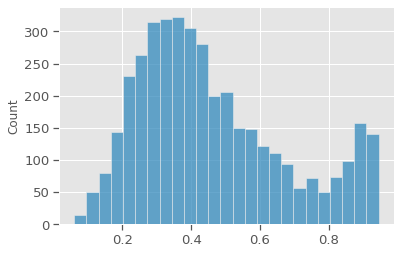

In [142]:
sns.histplot(y_pred)

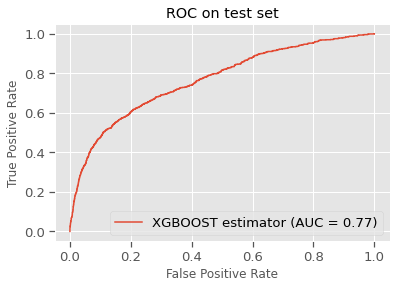

In [143]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBOOST estimator')
display.plot()
plt.title("ROC on test set")
plt.show()

> The following modifications were not effective on the final AUC

# Model Explainability

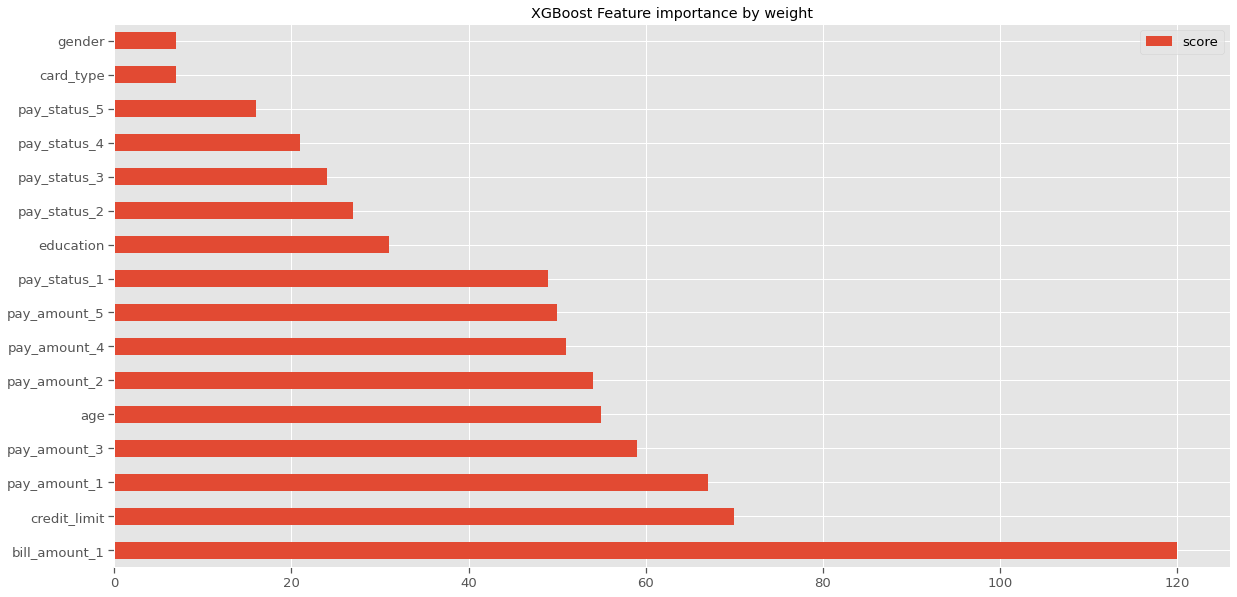

In [162]:
feature_important = bestGridModel.get_booster().get_score(importance_type='weight') # 'gain' or 'weight' give different results

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10))
plt.title("XGBoost Feature importance by weight")
plt.show()


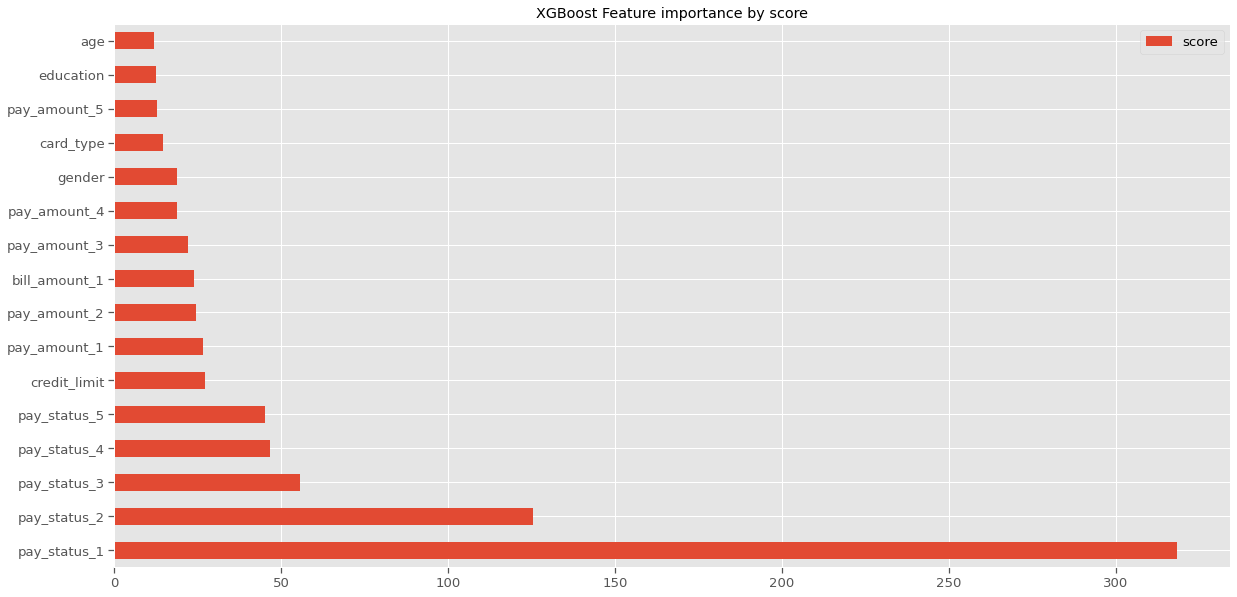

In [160]:
feature_important = bestGridModel.get_booster().get_score(importance_type='gain') # 'gain' or 'weight' give different results

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.plot(kind='barh', figsize = (20,10)) ## plot top 40 features
plt.title("XGBoost Feature importance by score")
plt.show()

# Conclusion

*	Null values in card_type were replaced as a new category
*	Education was grouped to contain less categories
*	The data needed no more cleaning
*	The target variable is around 80-20, therefore we have a imbalanced problem
*	Correlation was measured between features, bill_amount_i variables were highly correlated. XGBOOST is not sensitive to multicollinearity, however, I trained and tested the model both with and without them.
*	Pay_status_i was used as an ordinal variable as it contained information and went from -2 to 8. The higher meant, more delay in payment so it made sense.
*	The first XGboost model was relatively simple:
*	I picked learning rate =0.05 as it is common practice
*	Max_depth was 6 (around default for xgboost itself)
*	N_estimators were picked as 500 and no early_stopping was implemented as I wanted to plot overfitting
*	row_sample and col_sample were picked at 0.8 (not very low, not very high)

*	The evaluation metric at all model fitting processes was with AUC as it is not sensitive to the threshold picked (due to the imbalanced nature of our classification)
*	Xgboost like every ML model needs to be tuned. I used a variety of random and grid searches with cross validation to tune it. [Note: the test data was not a part of this process, I either used 5-fold-CV or a separate validation set]
*	scale_pos_weight was tuned and used to assign more importance to the positive class (credit defaults)
*	The tuned hyperparameters were used with the whole training data set + early stopping on the test set to create the final model
*	Bill_amount and pay_status and credit limit were the most important features in the ensemble method